In [84]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import signal

# this could possibly also be read from metadata (comment in the first lines of the csv)
# sampling rate in milliseconds
sampling_rate = 100

dance = pd.read_csv("../data/HIMU-2020-05-19_08-06-24.csv", skiprows=3)
dance['time'] = dance.reset_index().index * sampling_rate
dance.describe()

,accelerometer_lsm6ds3_c.x,accelerometer_lsm6ds3_c.y,accelerometer_lsm6ds3_c.z,linear_Acceleration.x,linear_Acceleration.y,linear_Acceleration.z,rotation_Vector.x,rotation_Vector.y,rotation_Vector.z,time
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,-0.673344,-6.592160,0.854155,-0.066730,-0.016694,-0.127715,-0.392739,0.424518,-0.117859,8050.000000
std,3.012476,5.364940,4.755133,1.828694,2.342598,1.488143,0.271276,0.205043,0.550302,4690.948731
min,-7.365723,-17.384605,-10.219688,-5.751900,-8.183900,-4.310300,-0.686178,-0.252990,-0.759597,0.000000
25%,-1.704932,-10.113333,-2.067123,-0.737425,-0.905650,-0.978325,-0.560507,0.295660,-0.445490,4025.000000
50%,-0.969891,-8.286547,-0.646420,0.040600,0.125500,-0.089900,-0.498702,0.501018,-0.376055,8050.000000
75%,-0.157998,-3.668295,1.018388,0.631925,1.434500,0.782675,-0.410995,0.571240,-0.230960,12075.000000
max,19.723875,4.636582,12.516015,9.362699,7.379300,5.812400,0.632153,0.667891,0.989761,16100.000000


Depending on what comments are in the csv-file (=lines starting with `@`) You might need to change the skipRows
parameter above.

Once we have imported a csv HyperIMU series, we want to start cleaning it.

But first, let's look at some parts of our dataFrame: the linear_acceleration and rotation_vector data

In [85]:
# dance[['linear_Acceleration.x', 'linear_Acceleration.y', 'linear_Acceleration.z']].plot()
# dance[['rotation_Vector.x', 'rotation_Vector.y', 'rotation_Vector.z']].plot()
for sensor in ('linear_Acceleration', 'rotation_Vector'):
    fig = go.Figure()
    for axis in ('%s.x', '%s.y', '%s.z'):
        fig.add_trace(go.Scatter(
        y = dance[axis % sensor],
        x = dance['time']/1000,
        mode = 'lines',
        name=axis
    ))
    fig.update_layout(title=sensor)
    fig.show()

From the rotation vector data, we can easily see that in this example the phone was probably moved to the pocket somewhere
around point 0-25 and out of the pocked around points 135 - 160.

Therefore we can just cut the dataset and use only the rows 25 to 135.

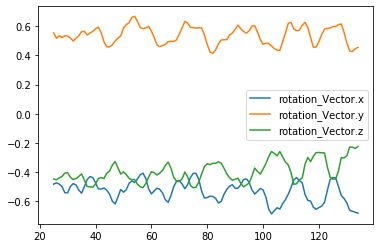

In [86]:
# the start and end variables can later be algorithmically approximated.
# For now, estimating them as constants based on the graph above works just fine.
# TODO: maybe this can also be approximated using the Ambient light sensor in the smartphone?
start=25
end=135
dance = dance.iloc[start:end]
dance[['rotation_Vector.x', 'rotation_Vector.y', 'rotation_Vector.z']].plot()

# Finding the peaks
For finding the peaks, we need to first find out what the bpm and beats per measure of our current song is:

Luckily, we can use the [get-audio-features spotify-API call](https://developer.spotify.com/console/get-audio-features-track/) for that.

If we call that API with the song ID of Ed Sheeran's Shape of You (```7qiZfU4dY1lWllzX7mPBI3```) we get the following response:


In [87]:
spotify_response = {
  "danceability": 0.825,
  "energy": 0.652,
  "key": 1,
  "loudness": -3.183,
  "mode": 0,
  "speechiness": 0.0802,
  "acousticness": 0.581,
  "instrumentalness": 0,
  "liveness": 0.0931,
  "valence": 0.931,
  "tempo": 95.977,
  "type": "audio_features",
  "id": "7qiZfU4dY1lWllzX7mPBI3",
  "uri": "spotify:track:7qiZfU4dY1lWllzX7mPBI3",
  "track_href": "https://api.spotify.com/v1/tracks/7qiZfU4dY1lWllzX7mPBI3",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/7qiZfU4dY1lWllzX7mPBI3",
  "duration_ms": 233713,
  "time_signature": 4
}
time_signature = spotify_response['time_signature']
bpm = spotify_response['tempo']
duration = spotify_response['duration_ms'] / 1000

time_between_beats = 60 / bpm
time_between_bars = time_between_beats * time_signature

# now let's add that beat information to the chart of the rotation axis:

def plot_series_with_beats(axis: str):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y = dance[axis],
        x = dance['time']/1000,
        mode = 'lines',
        name=axis
    ))

    ymin = dance[axis].min()
    ymax = dance[axis].max()

    # generate beat definitions
    shapes = []
    count = 0
    i = dance['time'].min()
    while i < dance['time'].max():
        count += 1
        i += int(time_between_beats * 1000)
        shapes.append(dict(type= 'line', xref= 'x', x0 =i/1000.0, x1 = i/1000.0, y0= ymin, y1= ymax))
        if count % time_signature == 0:
            shapes[-1]['line'] = dict(color="Red")
            # we color every fourth beat red to show how long a bar is (maybe misleading since this
            # is not necessarily the start or end of a bar


    fig.update_layout(title=axis, shapes = shapes)
    fig.show()

plot_series_with_beats('rotation_Vector.x')

Since we now have bot the dancing sensor signal and our metadata of the song,
we can now focus on calculating the rhythm of the dancer.

In [88]:
from scipy.signal import argrelextrema
import numpy as np

# calculate how many data points a beat is long
samples_per_second = 1000 / sampling_rate
samples_per_beat = samples_per_second * time_between_beats

def find_peaks_for_series(series: np.ndarray):
    order = int(samples_per_beat)
    peaks = argrelextrema(series, comparator=np.greater, order = order)[0]
    return peaks

def find_peak_diffs(series: pd.Series):
    peaks = find_peaks_for_series(series.values)
    time_stamps = dance['time'].values
    diff_peak = np.diff(time_stamps[peaks], n = 1)
    return diff_peak

def visualize_peaks(axis: str):
    peaks = find_peaks_for_series(dance[axis].values)
    time_stamps = dance['time'].values

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y = dance[axis],
        x = dance['time']/1000,
        mode = 'lines',
        name=axis
    ))

    fig.add_trace(go.Scatter(
        x=[time_stamps[j]/1000 for j in peaks],
        y=[dance[axis].values[j] for j in peaks],
        mode='markers',
        marker=dict(
            size=8,
            color='red',
            symbol='cross'
        ),
        name='Detected Peaks'
    ))

    fig.show()

# local_maxima = find_peaks_for_series(dance['rotation_Vector.z'].values)
# local_minima = find_peaks_for_series(-dance['rotation_Vector.z'].values)
# extrema = np.concatenate(local_maxima, local_minima)
# extrema

visualize_peaks('rotation_Vector.z')
find_peak_diffs(dance['rotation_Vector.z'])

array([1700, 1900, 1800, 1900, 1700])

On first glance it looks like in this time series we found a rhythm of the person moving every approximately 1.8 seconds
(or twice that speed if we assume both negative and positive peaks are a movement?)

TODO:
- Check if other axis have similar peaks and peakDiffs
- Check how we can best compare beat and peakDiff values
- Calculate consistency in movement (stddev of peakDiffs?)

some more [inspiration](https://github.com/gutosantos82/RiMoDe)
